# Cycle GAN

In this notebook we are going to implement the CycleGAN Architecture

### Setup Pytorch

In [1]:
######################################################################
#                       Setup python environment                     #
######################################################################
# !pip install torch torchvision
# conda update pytorch torchvision

In [1]:
import argparse
import os
import numpy as np
import math
import itertools
import datetime
import time
import h5py

import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils import data
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt

### Utility functions

In [3]:
import random
import sys

class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))


class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

### Models

In [21]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


##############################
#           RESNET
##############################


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            # Pads the input tensor using the reflection of the input boundary.
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    """
    Defines the architecture of the generator network.
       Note: Both generators G_AtoB and G_BtoA have the same architecture in this assignment.
    """
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        in_channels = input_shape[0]

        # Initial convolution block (first convolutional layer)
        out_features = 64 
        model = [
            # Pads the input tensor using the reflection of the input boundary.
            nn.ReflectionPad2d(in_channels), 
            # Conv2d(in_channels, out_channels, kernel_size=7, stride=1, padding=0)
            nn.Conv2d(in_channels, out_features, 7), 
            # Applies Instance Normalization over a 4D input
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            print(out_features)
            model += [
                # Upsamples a given multi-channel data. Double the spatial space.
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        # we should make sure that the result of the generator have the same size as of the input image
        model += [nn.ReflectionPad2d(in_channels), nn.Conv2d(out_features, in_channels, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        """
        Generates an image conditioned on an input image.

            Input
            -----
                x: BatchSize x 3 x 16 x 16

            Output
            ------
                out: BatchSize x 3 x 16 x 16
        """
        batch_size = x.size(0)
        out_size = self.model(x).size()
        if out_size != torch.Size([batch_size, 3, 16, 16]):
            raise ValueError("expect {} x 3 x 16 x 16, but get {}".format(batch_size, out_size))

        return self.model(x)

##############################
#        Discriminator
##############################


class Discriminator(nn.Module):
    """
    Defines the architecture of the discriminator network.
       Note: Both discriminators D_A and D_B have the same architecture in this assignment.
    """
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

In [28]:
parser = argparse.ArgumentParser()
parser.add_argument("--epoch", type=int, default=0, help="epoch to start training from")
parser.add_argument("--n_epochs", type=int, default=50, help="number of epochs of training")
parser.add_argument("--dataset_name", type=str, default="MNIST2USPS", help="name of the dataset")
parser.add_argument("--batch_size", type=int, default=100, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--decay_epoch", type=int, default=20, help="epoch from which to start lr decay")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--img_height", type=int, default=16, help="size of image height")
parser.add_argument("--img_width", type=int, default=16, help="size of image width")
parser.add_argument("--img_size", type=int, default=16, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=3, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=10, help="interval between saving generator outputs")
parser.add_argument("--checkpoint_interval", type=int, default=-1, help="interval between saving model checkpoints")
parser.add_argument("--n_residual_blocks", type=int, default=9, help="number of residual blocks in generator")
parser.add_argument("--lambda_cyc", type=float, default=10.0, help="cycle loss weight")
parser.add_argument("--lambda_id", type=float, default=5.0, help="identity loss weight")
opt = parser.parse_args("")

print(opt)

Namespace(b1=0.5, b2=0.999, batch_size=100, channels=3, checkpoint_interval=-1, dataset_name='MNIST2USPS', decay_epoch=20, epoch=0, img_height=16, img_size=16, img_width=16, lambda_cyc=10.0, lambda_id=5.0, lr=0.0002, n_cpu=8, n_epochs=50, n_residual_blocks=9, sample_interval=10)


### Datasets

In [6]:
import glob
import random
import os

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms


def to_rgb(image_tensor):
    trans = transforms.ToPILImage()
    pil_img = trans(image_tensor)
    # rgb_image = rgb_image.convert('RGB')
    rgb_image = Image.new("RGB", pil_img.size)
    rgb_image.paste(pil_img)
    return rgb_image


class MergedDataset(Dataset):
    '''
    The MergedDataset class convert grayscale images into 3 channel RGB images
    And merges two datasets of different styles into one dataset.
    '''
    def __init__(self, dataset_A, dataset_B, transforms_=None, unaligned=False, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        self.dataset_A = dataset_A
        self.dataset_B = dataset_B

    def __getitem__(self, index):
        image_A = self.dataset_A[index % len(self.dataset_A)][0]

        if self.unaligned:
            image_B = self.dataset_B[random.randint(0, len(self.dataset_B) - 1)][0]
        else:
            image_B = self.dataset_B[index % len(self.dataset_B)][0]

        # Convert grayscale images to rgb
        image_A = to_rgb(image_A)
        image_B = to_rgb(image_B)
        
        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {"A": item_A, "B": item_B}

    def __len__(self):
        return max(len(self.dataset_A), len(self.dataset_B))

### Download Translation datasets

In [7]:
# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)

MNIST_trainset = datasets.MNIST(
                    "../../data/mnist",
                    train=True,
                    download=True,
                    transform=transforms.Compose(
                        [transforms.Resize(opt.img_size), transforms.ToTensor()] 
                        # transforms.Normalize((0.1307,), (0.3081,))
                        # We used the mean and std of mnist dataset to normalize the data
                        # However it doesn't work well.
                    ),
                )
MNIST_testset = datasets.MNIST(
                    "../../data/mnist",
                    train=False,
                    download=True,
                    transform=transforms.Compose(
                        [transforms.Resize(opt.img_size), transforms.ToTensor()] 
                    ),
                )
mnist_trainloader = DataLoader(MNIST_trainset, batch_size=opt.batch_size, shuffle=True)
mnist_testloader = DataLoader(MNIST_testset, batch_size= opt.batch_size, shuffle=False)

torch.Size([1, 1, 16, 16])
torch.Size([1, 16, 16])


Text(0.5, 1.0, 'An Example from MNIST Dataset: Ground Truth is 7')

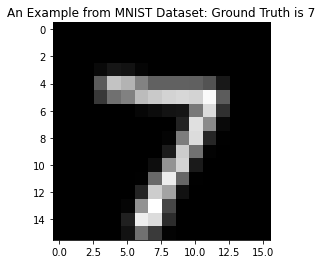

In [8]:
examples_mnist = enumerate(mnist_testloader)
batch_idx_mnist, (example_data_mnist, example_targets_mnist) = next(examples_mnist)
print(example_data_mnist.shape)
print(example_data_mnist[0].shape)

# plot an example from the dataloader
plt.imshow(example_data_mnist[0][0], cmap='gray', interpolation='none')
plt.title("An Example from MNIST Dataset: Ground Truth is {}".format(example_targets_mnist[0]))


In [9]:
import h5py
with h5py.File('./data/usps.h5', 'r') as hf:
    train = hf.get('train')
    X_tr = train.get('data')[:]
    y_tr = train.get('target')[:].astype(int)
    test = hf.get('test')
    X_te = test.get('data')[:]
    y_te = test.get('target')[:].astype(int)

# The data were in an 1D numpy array of grayscale and normalised between [0,1]
# We transform the data into the same dimensions as for the mnist.
X_tr = X_tr.reshape(-1,1,16,16) #*255 
X_te = X_te.reshape(-1,1,16,16) #*255

In [10]:
USPS_trainset = data.TensorDataset(torch.Tensor(X_tr),torch.Tensor(y_tr))
USPS_testset = data.TensorDataset(torch.Tensor(X_te),torch.Tensor(y_te)) 

usps_trainloader = DataLoader(USPS_trainset, batch_size=opt.batch_size, 
                              shuffle=True, num_workers=opt.n_cpu)
usps_testloader = DataLoader(USPS_testset, batch_size=opt.batch_size, 
                             shuffle=False, num_workers=opt.n_cpu)


torch.Size([1, 1, 16, 16])
torch.Size([1, 16, 16])


Text(0.5, 1.0, 'An Example from USPS Dataset: Ground Truth is 9.0')

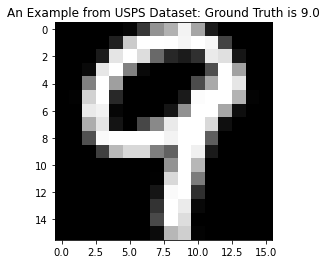

In [11]:
examples_usps = enumerate(usps_testloader)
batch_idx_usps, (example_data_usps, example_targets_usps) = next(examples_usps)
print(example_data_usps.shape)
print(example_data_usps[0].shape)

# plot an example from the dataloader
plt.imshow(example_data_usps[0][0], cmap='gray', interpolation='none')
plt.title("An Example from USPS Dataset: Ground Truth is {}".format(example_targets_usps[0]))


In [14]:
# Image transformations
transforms_ = [
    transforms.Resize(int(opt.img_height), Image.BICUBIC),
    ## Add some noise into the data
    transforms.RandomCrop((opt.img_height, opt.img_width)),
    ## Random flip on image
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    ## Normalise data
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]

# Training data loader
dataloader = DataLoader(
    MergedDataset(MNIST_trainset, USPS_trainset, transforms_=transforms_, unaligned=True),
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=0 #opt.n_cpu
)

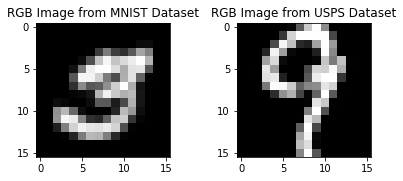

In [15]:
examples = enumerate(dataloader)
batch_idx, batch = next(examples)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(batch['A'][0].transpose(1,2).transpose_(0,2))
axes[0].set_title("RGB Image from MNIST Dataset")

axes[1].imshow(batch['B'][0].transpose(1,2).transpose_(0,2))
axes[1].set_title("RGB Image from USPS Dataset")
plt.subplots_adjust(wspace = 0.5)
plt.show()


In [29]:
# Create sample and checkpoint directories
os.makedirs("images/%s" % opt.dataset_name, exist_ok=True)
os.makedirs("saved_models/%s" % opt.dataset_name, exist_ok=True)

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

cuda = torch.cuda.is_available()

input_shape = (opt.channels, opt.img_height, opt.img_width)

# Initialize generator and discriminator
G_AtoB = GeneratorResNet(input_shape, opt.n_residual_blocks)
G_BtoA = GeneratorResNet(input_shape, opt.n_residual_blocks)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

if cuda:
    G_AtoB = G_AtoB.cuda()
    G_BtoA = G_BtoA.cuda()
    D_A = D_A.cuda()
    D_B = D_B.cuda()
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

if opt.epoch != 0:
    # Load pretrained models
    G_AtoB.load_state_dict(torch.load("saved_models/%s/G_AtoB_%d.pth" % (opt.dataset_name, opt.epoch)))
    G_BtoA.load_state_dict(torch.load("saved_models/%s/G_BtoA_%d.pth" % (opt.dataset_name, opt.epoch)))
    D_A.load_state_dict(torch.load("saved_models/%s/D_A_%d.pth" % (opt.dataset_name, opt.epoch)))
    D_B.load_state_dict(torch.load("saved_models/%s/D_B_%d.pth" % (opt.dataset_name, opt.epoch)))
else:
    # Initialize weights
    G_AtoB.apply(weights_init_normal)
    G_BtoA.apply(weights_init_normal)
    D_A.apply(weights_init_normal)
    D_B.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(G_AtoB.parameters(), G_BtoA.parameters()), lr=opt.lr, betas=(opt.b1, opt.b2)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

# Learning rate update schedulers
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step
)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step
)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step
)

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

# Buffers of previously generated samples
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# Image transformations
transforms_ = [
    transforms.Resize(int(opt.img_height), Image.BICUBIC),
    ## Add some noise into the data
    transforms.RandomCrop((opt.img_height, opt.img_width)),
    ## Random flip on image
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    ## Normalise data
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]

# Training data loader
dataloader = DataLoader(
    MergedDataset(MNIST_trainset, USPS_trainset, transforms_=transforms_, unaligned=True),
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=0 # opt.n_cpu
)

# Test data loader
val_dataloader = DataLoader(
    MergedDataset(MNIST_testset, USPS_testset, transforms_=transforms_, unaligned=True, mode="test"),
    batch_size=5,
    shuffle=True,
    num_workers=0 #1,
)

def sample_images(batches_done):
    """Saves a generated sample from the test set"""
    imgs = next(iter(val_dataloader))
    G_AtoB.eval()
    G_BtoA.eval()
    real_A = Variable(imgs["A"].type(Tensor))
    fake_B = G_AtoB(real_A)
    real_B = Variable(imgs["B"].type(Tensor))
    fake_A = G_BtoA(real_B)
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    save_image(image_grid, "images/%s/%s.png" % (opt.dataset_name, batches_done), normalize=False)


# ----------
#  Training
# ----------

prev_time = time.time()
for epoch in range(opt.epoch, opt.n_epochs):
    for i, batch in enumerate(dataloader):

        # Set model input
        real_A = Variable(batch["A"].type(Tensor))
        real_B = Variable(batch["B"].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        G_AtoB.train()
        G_AtoB.train()

        optimizer_G.zero_grad()

        # Identity loss
        loss_id_A = criterion_identity(G_BtoA(real_A), real_A)
        loss_id_B = criterion_identity(G_AtoB(real_B), real_B)

        loss_identity = (loss_id_A + loss_id_B) / 2

        # GAN loss
        fake_B = G_AtoB(real_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        fake_A = G_BtoA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)

        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        
        # Cycle loss
        recov_A = G_BtoA(fake_B)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        recov_B = G_AtoB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)

        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

        # Total loss
        loss_G = loss_GAN + opt.lambda_cyc * loss_cycle + opt.lambda_id * loss_identity

        loss_G.backward()
        optimizer_G.step()

        # -----------------------
        #  Train Discriminator A
        # -----------------------

        optimizer_D_A.zero_grad()

        # Real loss
        loss_real = criterion_GAN(D_A(real_A), valid)
        # Fake loss (on batch of previously generated samples)
        fake_A_ = fake_A_buffer.push_and_pop(fake_A)
        loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
        # Total loss
        loss_D_A = (loss_real + loss_fake) / 2

        loss_D_A.backward()
        optimizer_D_A.step()

        # -----------------------
        #  Train Discriminator B
        # -----------------------

        optimizer_D_B.zero_grad()

        # Real loss
        loss_real = criterion_GAN(D_B(real_B), valid)
        # Fake loss (on batch of previously generated samples)
        fake_B_ = fake_B_buffer.push_and_pop(fake_B)
        loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
        # Total loss
        loss_D_B = (loss_real + loss_fake) / 2

        loss_D_B.backward()
        optimizer_D_B.step()

        loss_D = (loss_D_A + loss_D_B) / 2

        # --------------
        #  Log Progress
        # --------------

        # Determine approximate time left
        batches_done = epoch * len(dataloader) + i
        batches_left = opt.n_epochs * len(dataloader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        # Print log
        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f] ETA: %s"
            % (
                epoch,
                opt.n_epochs,
                i,
                len(dataloader),
                loss_D.item(),
                loss_G.item(),
                loss_GAN.item(),
                loss_cycle.item(),
                loss_identity.item(),
                time_left,
            )
        )

        # If at sample interval save image
        if batches_done % opt.sample_interval == 0:
            sample_images(batches_done)

    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    if opt.checkpoint_interval != -1 and epoch % opt.checkpoint_interval == 0:
        # Save model checkpoints
        torch.save(G_AtoB.state_dict(), "saved_models/%s/G_AtoB_%d.pth" % (opt.dataset_name, epoch))
        torch.save(G_BtoA.state_dict(), "saved_models/%s/G_BtoA_%d.pth" % (opt.dataset_name, epoch))
        torch.save(D_A.state_dict(), "saved_models/%s/D_A_%d.pth" % (opt.dataset_name, epoch))
        torch.save(D_B.state_dict(), "saved_models/%s/D_B_%d.pth" % (opt.dataset_name, epoch))

128
64
128
64
[Epoch 0/50] [Batch 3/600] [D loss: 0.499400] [G loss: 7.874822, adv: 0.998800, cycle: 0.461459, identity: 0.452287] ETA: 38 days, 7:20:03.5153502

KeyboardInterrupt: 